In [3]:
import pandas as pd 
import pymongo
from pprint import pprint

import numpy as np
import scipy.sparse as ss
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer

from corextopic import corextopic as ct
from corextopic import vis_topic as vt # jupyter notebooks will complain matplotlib is being loaded twice

In [4]:
##### INIT GLOBAL VARIABLES#####

#init Mongo
conn = 'mongodb://localhost:27017'
client = pymongo.MongoClient(conn)

#connect to database
db = client.visualizing_sep

In [7]:
sep_df = pd.DataFrame(list(db.sep_entries.find({}, 
                                                projection=['title', 'preamble_text'], 
                                                sort=[('title',1)])))

In [8]:
sep_df.head()

,_id,title,preamble_text
0,5f1bb235896f82cdbda61077,17th and 18th Century Theories of Emotions,Early modern philosophy in Europe and Great Br...
1,5f1baf2c896f82cdbda60ed2,18th Century British Aesthetics,18th-century British aesthetics addressed itse...
2,5f1baf2d896f82cdbda60ed3,18th Century French Aesthetics,French philosophers of the Ancien Régime wrote...
3,5f1baf2f896f82cdbda60ed4,18th Century German Aesthetics,The philosophical discipline of aesthetics did...
4,5f1baf09896f82cdbda60ebf,18th Century German Philosophy Prior to Kant,"In Germany, the eighteenth century was the age..."


In [9]:
vectorizer = CountVectorizer(stop_words='english', max_features=20000, binary=True)
doc_word = vectorizer.fit_transform(sep_df['preamble_text'])
doc_word = ss.csr_matrix(doc_word)

doc_word.shape # n_docs x m_words

(1692, 20000)

In [10]:
# Get words that label the columns (needed to extract readable topics and make anchoring easier)
words = list(np.asarray(vectorizer.get_feature_names()))


In [11]:
not_digit_inds = [ind for ind,word in enumerate(words) if not word.isdigit()]
doc_word = doc_word[:,not_digit_inds]
words    = [word for ind,word in enumerate(words) if not word.isdigit()]

doc_word.shape # n_docs x m_words

(1692, 19048)

In [12]:
# Train the CorEx topic model with 50 topics
topic_model = ct.Corex(n_hidden=20, words=words, max_iter=200, verbose=False, seed=1)
topic_model.fit(doc_word, words=words);

In [13]:
# Print a single topic from CorEx topic model
topic_model.get_topics(topic=1, n_words=10)

[('china', 0.02327623420904738),
 ('confucian', 0.019177288721034864),
 ('genes', 0.01619434886929686),
 ('process', 0.01562510354549919),
 ('confucianism', 0.015249912867131515),
 ('genetics', 0.013140513213828104),
 ('gene', 0.012451679667175954),
 ('inner', 0.01121808240454554),
 ('working', 0.010511623712911047),
 ('rich', 0.010279577752889166)]

In [16]:
# Print all topics from the CorEx topic model
topics = topic_model.get_topics()
for n,topic in enumerate(topics):
    topic_words,_ = zip(*topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: society,rights,political,social,economic,institutions,public,government,legal,politics
1: theorem,ldots,theorems,amp,rightarrow,axioms,aaa,theoretic,variables,bbb
2: moral,morally,lives,harm,morality,goods,persons,people,person,duty
3: published,wrote,university,died,born,writings,intellectual,career,books,teaching
4: culture,cultural,practices,life,history,movement,historical,western,cultures,european
5: divine,god,theology,christian,theological,religious,spiritual,perfection,eternal,religion
6: plausible,suppose,objection,worry,isn,count,think,doesn,don,facts
7: sentences,semantics,semantic,sentence,propositional,predicate,quantifiers,logical,predicates,frege
8: soul,aristotle,aristotelian,texts,latin,treatise,commentary,commentaries,treatises,greek
9: normative,argue,theorists,responses,challenge,counts,response,beliefs,tend,agents
10: processes,al,mechanisms,research,biology,environment,biological,researchers,networks,environmental
11: mechanics,physics,experimental,mathematical

In [14]:


print(topic_model.clusters)
print(topic_model.clusters.shape) # m_words



[0 0 7 ... 0 0 1]
(19048,)


In [16]:
# Print a single topic from CorEx topic model
topic0_topdocs = topic_model.get_top_docs(topic=0, n_docs=10, sort_by='log_prob')


NOTE: 'docs' not provided to CorEx. Returning top docs as lists of row indices


In [38]:
for doc in topic0_topdocs:
    rowNumber = doc[0]
    print(rowNumber)


845
796
781
774
771
764
761
755
752
750


In [39]:

print(topic_model.labels.shape)

(1692, 20)


In [40]:


topic_model.tc



42.205051224746754

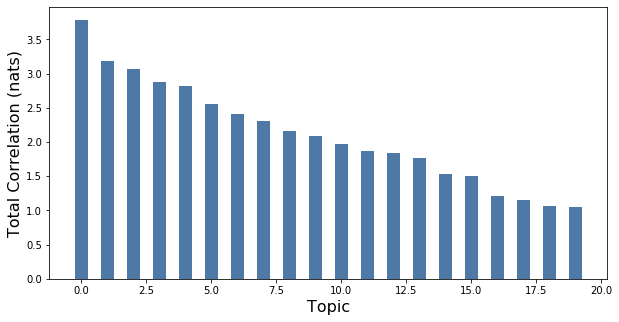

In [41]:
plt.figure(figsize=(10,5))
plt.bar(range(topic_model.tcs.shape[0]), topic_model.tcs, color='#4e79a7', width=0.5)
plt.xlabel('Topic', fontsize=16)
plt.ylabel('Total Correlation (nats)', fontsize=16);

In [42]:
topic_model.log_z.shape # n_docs x k_topics

(1692, 20)

In [43]:
print(topic_model.tcs)

[3.78473547 3.18882827 3.06285579 2.87636888 2.81613573 2.55085212
 2.41061305 2.30100618 2.16249753 2.09177489 1.96410068 1.86647504
 1.84508012 1.76885278 1.53468127 1.50041949 1.20562057 1.15074405
 1.06905588 1.05435345]


In [47]:
# Anchors designed to nudge the model towards measuring specific genres
anchor_words = [
    ["Political Philosophy", "Political Theory",  "Social Theory", "Government", "Justice", "Rights", "Civic"],
    ["Philosophy of Science", "Science", "natural philosophy", "scientific"],
    ["Philosophy of Religion", "religion", "god", "faith", "theology"],
    ["Philosophy of Mind", "Metaphysics of Mind", "mental", "consciousness", "perception", "cognition", "emotion"],
    ["Philosophy of Mathematics", "Mathematics", "mathematical", "algebra", "calculus", "geometry", "probability", "statistics", "set theory"],
    ["Philosophy of Law", "law", "tort", "legal", "testimony"],
    ["Philosophy of Language", "semantics", "pragmatics", "linguistics", "grammar"],
    ["Metaphysics", "causation", "ontology"],
    ["Logic", "inference", "paradox"],
    ["Latin American Philosophy", "Latin America", "Iberian Peninsula", "mexico", "chile"],
    ["Jewish philosophy", "Judaic Philosophy", "Hebrew Philosophy"],
    ["Japanese philosophy"],
    ["Feminist Philosophy", "feminism", "feminist"],
    ["Ethics", "Ethical Philosophy", "Moral Philosophy", "Morals", "Morality"],
    ["Epistemology",  "epistemic", "knowledge", "truth"],
    ["Existentialism", "Phenomenolgy", "Intentionality", "Hermeneutics", "Critical Theory", "PostModernism"],
    ["Chinese Philosophy", "Chinese Medicine", "Tibet"],
    ["Arabic and Islamic", "Islamic", "Middle Eastern", "Koran", "Muslim"],
    ["Africa", "African", "Africana", "African-American"],
    ["Aesthetic", "Aesthetics", "Art", "Film", "Music", "Dance", "Theater"]
]

anchored_topic_model = ct.Corex(n_hidden=20, seed=2)
anchored_topic_model.fit(doc_word, words=words, anchors=anchor_words, anchor_strength=10)



In [48]:
# Print all topics from the CorEx topic model
anchored_topics = anchored_topic_model.get_topics()
for n,anchored_topic in enumerate(anchored_topics):
    topic_words,_ = zip(*anchored_topic)
    print('{}: '.format(n) + ','.join(topic_words))

0: scientific,science,sciences,biology,evolutionary,scientists,explanation,study,natural,genetics
1: religion,god,theology,faith,christian,religious,divine,theological,jewish,ibn
2: mental,perception,consciousness,cognition,emotion,mind,experience,brain,world,objects
3: mathematical,probability,calculus,geometry,algebra,statistics,mathematics,proof,theorem,theorems
4: law,legal,testimony,political,social,institutions,moral,justice,rights,public
5: semantics,linguistics,grammar,pragmatics,logic,language,logical,sentences,sentence,formal
6: ontology,causation,causal,substances,structures,competition,substance,portions,reflect,yield
7: inference,paradox,example,question,way,say,like,case,terms,things
8: mexico,particular,order,differences,far,meaning,form,better,implications,subject
9: feminist,feminism,women,feminists,gender,oppression,race,sex,including,western
10: knowledge,truth,epistemic,true,belief,epistemological,epistemology,false,propositions,proposition
11: cultural,literary,art

In [46]:
anchored_topics.get_top_docs(topic=0, n_docs=20, sort_by='log_prob')

AttributeError: 'list' object has no attribute 'get_top_docs'